In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

from models import *
from config import *

Using TensorFlow backend.


### Loading ground truth and generating mask from prediction

In [4]:
model = base_model(verbose=False)
model.load_weights(EXAMPLE_MODEL)

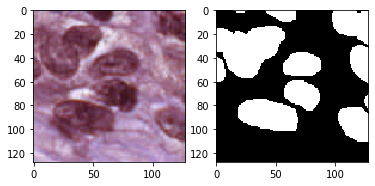

In [5]:
names = [f for f in os.listdir(PATCH_IMG_PATH) if f.count('_') < 3]

img = cv2.imread(PATCH_IMG_PATH + names[1])
ground_truth = cv2.imread(PATCH_MASK_PATH + names[1], cv2.IMREAD_GRAYSCALE) 

fig=plt.figure(figsize=(6, 3))

fig.add_subplot(1, 2, 1)
plt.imshow(img)
fig.add_subplot(1, 2, 2)
plt.imshow(ground_truth, cmap='gray')

1/1 [==============================] - 0s 228ms/step


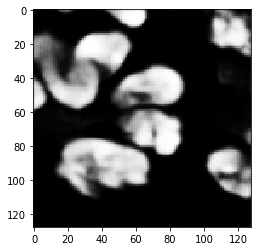

In [6]:
to_pred = np.zeros((1,*img.shape))
to_pred[0] = img
predicted = model.predict(to_pred, verbose=1)
predicted = np.squeeze(predicted)

plt.imshow(predicted, cmap='gray')

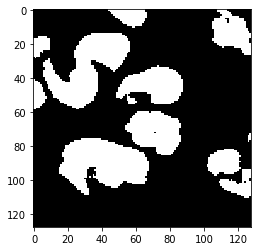

In [7]:
mask = predicted * 255
mask = mask.astype(dtype='uint8')
_, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_OTSU)
plt.imshow(mask, cmap='gray')

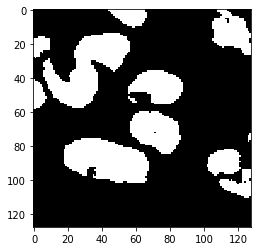

In [8]:
_ground_truth = ground_truth/255
_mask = mask/255
_intersection = _ground_truth * _mask
plt.imshow(_intersection, cmap='gray')

### Ground truth cells

Number of cells in the ground truth: 12


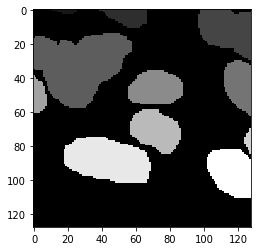

In [9]:
no_cells, cells = cv2.connectedComponents(ground_truth)
plt.imshow(cells*20, cmap='gray')
print("Number of cells in the ground truth: " + str(no_cells))

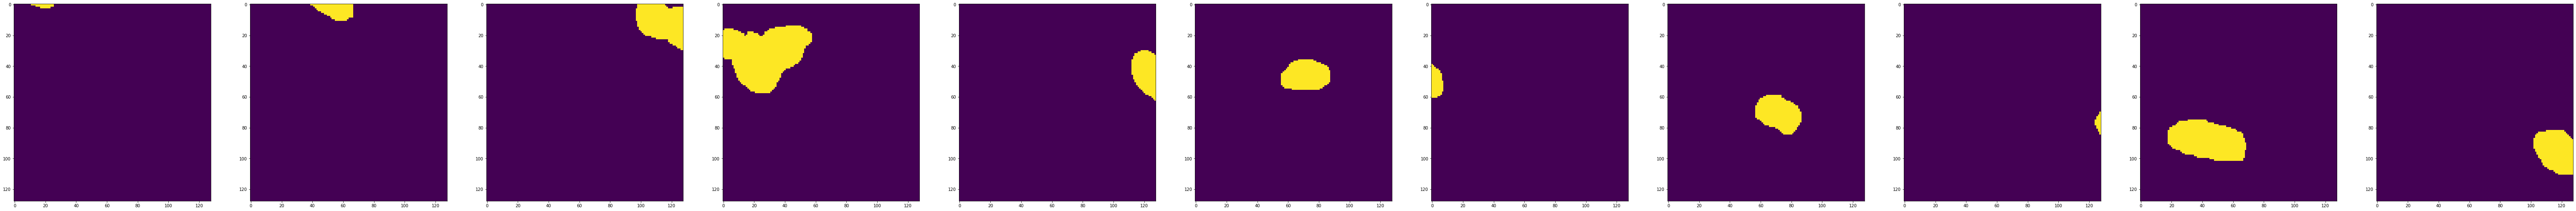

In [10]:
fig=plt.figure(figsize=(10*no_cells, 10))

for i in range(1, no_cells):
    cell = cells == i
    fig.add_subplot(1, no_cells, i)
    plt.imshow(cell)

### Generated mask cells

Number of cells in the generated mask: 13


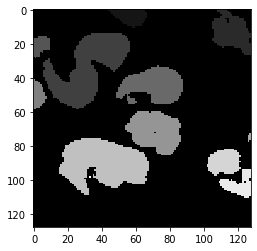

In [11]:
no_detected_cells, detected_cells = cv2.connectedComponents(mask)
plt.imshow(detected_cells * 20, cmap='gray')
print("Number of cells in the generated mask: " + str(no_detected_cells))

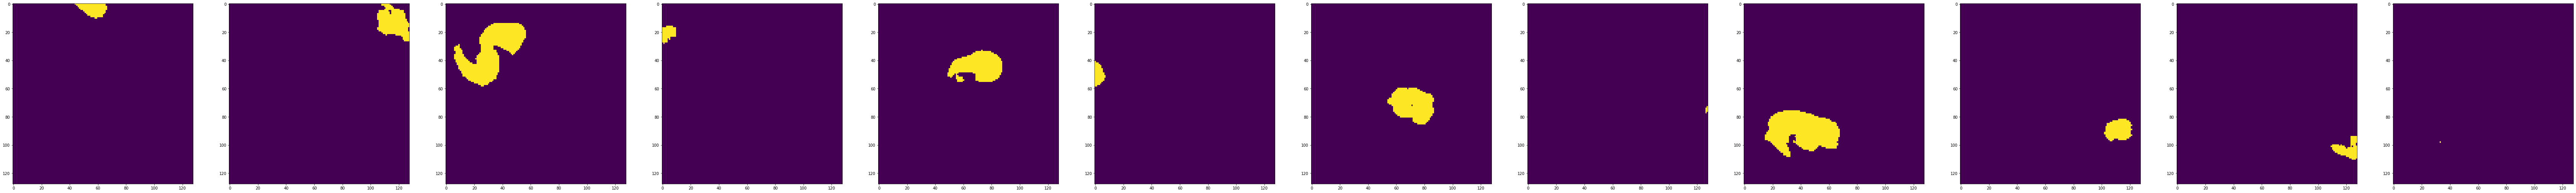

In [12]:
fig=plt.figure(figsize=(10*no_detected_cells, 10))

for i in range(1, no_detected_cells):
    cell = detected_cells == i
    fig.add_subplot(1, no_detected_cells, i)
    plt.imshow(cell)

### Calculation of TP and FN (detected at least by 50% of area)

In [13]:
tp = 0
fn = 0

for i in range(1, no_cells):
    # get cell
    cell = cells == i
    
    # find if at least 50% of the cell was detected
    if (cell * _intersection).sum() >= (cell.sum()/2):
        tp += 1
    else:
        fn += 1
    
    # update mask and intersection (so that one cell is not counted multiple times)
    detected_cell_indices = np.unique(cell*detected_cells)
    _mask[np.isin(detected_cells, detected_cell_indices)] = 0
    _intersection = _ground_truth * _mask
    
print('TP: ' + str(tp))
print('FN: ' + str(fn))

TP: 8
FN: 3


### Calculation of FP and TN 


FP - detected cells which were not present in the ground truth

TN - 1 if at least 50% of background was detected

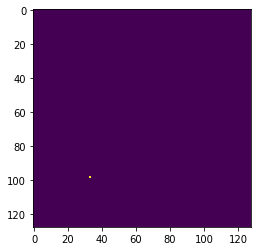

In [14]:
remaining_cells = detected_cells * _mask
plt.imshow(remaining_cells)

In [15]:
fp = len(np.unique(remaining_cells)) - 1
fp

1

In [16]:
tn = 1 if (detected_cells==0).sum() >= (cells==0).sum()/2 else 0
tn

1

### Accuracy

In [17]:
(tp + tn) / (tp + fn + fp + 1)

0.6923076923076923

### Actual function use

In [18]:
import metrics 

metrics.cell_count_accuracy(ground_truth, mask)

0.6923076923076923

In [19]:
metrics.cell_count_accuracy(ground_truth, mask, return_raw=True)

(8, 1, 1, 3)